# 가위, 바위, 보!
가위바위보 이미지 데이터셋를 이용해 가위, 바위, 보를 분류해보자
- [Teachable Machine](https://teachablemachine.withgoogle.com/) 사이트에서 직접 데이터셋 생성
- 데이터셋 모음(아이펠 교육생 데이터)[가위바위보 데이터셋](https://www.notion.so/modulabs/E-1-7fbdccfc3f2a453c8cf1670c2e76b7c8)
- TensorFlow를 이용해 딥러닝 모델 구축

### 목차
0. 데이터 확인 : 종류 및 개수 확인, 시각화
1. 데이터 전처리 및 불러오기 : 사이즈 변경, 불러오기, 병합, 변환, Standardization
2. 딥러닝 모델 설계 및 학습 : 정의, 컴파일, 모델학습
3. 결과 확인 : Accuracy, Confusion Matrix, Report

In [1]:
import os
import glob
import random

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from PIL import Image
%matplotlib inline

pont_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname=pont_path, size=18)

# 0. 데이터 확인
- 다른 교육생들과 공유하여 데이터양 Up
- 224x224 이미지를 28x28로 Resize(컬러이미지, Channel = 3)
- 교육생 8명을 학습데이터, 다른 교육생 7명을 테스트 데이터로 사용

In [18]:
TARGET_SIZE = (28, 28)
EPOCH = 30

### 0-1. 데이터 확인 : 종류 및 개수 확인

In [2]:
base_dir = os.getenv("HOME") + '/aiffel/rock_scissor_paper/data'
classes = ['rock', 'scissor', 'paper']
train_list = ['사공', '수완', '호성','승민','재성', '지윤', '은서', '정식']
test_list = ['민지', '범진', '보경', '영민', '은영', '재준', '효정']

print('Name (rock, scissor, paper)')

print('*' * 4, 'Train Dataset', '*' * 8)
for name in train_list:
    len_rock = len(glob.glob(os.path.join(base_dir, name, 'rock/*.jpg')))
    len_scissor = len(glob.glob(os.path.join(base_dir, name, 'scissor/*.jpg')))
    len_paper = len(glob.glob(os.path.join(base_dir, name, 'paper/*.jpg')))
    print(name, (len_rock, len_scissor, len_paper))

print('*' * 4, 'Test Dataset', '*' * 8)
for name in test_list:
    len_rock = len(glob.glob(os.path.join(base_dir, name, 'rock/*.jpg')))
    len_scissor = len(glob.glob(os.path.join(base_dir, name, 'scissor/*.jpg')))
    len_paper = len(glob.glob(os.path.join(base_dir, name, 'paper/*.jpg')))
    
    print(name, (len_rock, len_scissor, len_paper))

Name (rock, scissor, paper)
**** Train Dataset ********
사공 (122, 111, 117)
수완 (101, 102, 102)
호성 (100, 100, 100)
승민 (100, 100, 100)
재성 (100, 100, 100)
지윤 (100, 100, 100)
은서 (103, 101, 103)
정식 (106, 113, 105)
**** Test Dataset ********
민지 (100, 100, 100)
범진 (100, 100, 100)
보경 (100, 100, 100)
영민 (100, 100, 100)
은영 (100, 100, 100)
재준 (100, 100, 100)
효정 (101, 101, 101)


### 0-1. 데이터 확인 : 시각화

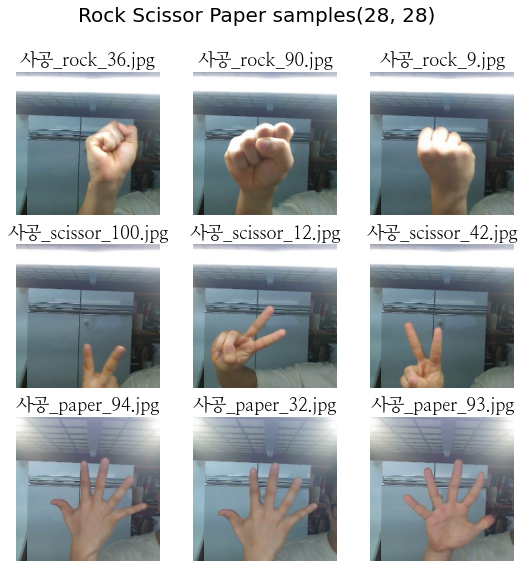

In [21]:
def get_image_sample(name, cls, sample=3):
    image_dir = os.path.join(base_dir, name, cls)
    image_list = glob.glob(image_dir + '/*.jpg')
    
    samples = random.sample(image_list, sample)
    
    return samples

rock_samples = get_image_sample('사공', 'rock')
scissor_samples = get_image_sample('사공', 'scissor')
paper_samples = get_image_sample('사공', 'paper')

sample_list = rock_samples + scissor_samples + paper_samples

plt.figure(figsize=(9,9))
plt.suptitle(F'Rock Scissor Paper samples{TARGET_SIZE}', fontsize=20)
for i, image_path in enumerate(sample_list):
    image = Image.open(image_path)
    filename = image_path.split('/')[-1]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(filename, fontproperties=fontprop)
    plt.axis('off')

# 1. 데이터 전처리 및 불러오기
분석에 활용할 수 있도록 데이터를 전처리를 한 후 불러왔다.
1. 데이터 사이즈 변경(228x228 to 114x114)
2. 각각의 이미지 데이터를 불러온 후 병합 및 배열(array) 자료형으로 변환
3. Normalization 적용(tensorflow Layer 활용)
3. Exploration 1-7노드에 있는 코드를 참고

#### 변경 사항
- 데이터의 총 개수가 달라져도 오류가 나지 않도록 ```load_data()```함수를 수정했다.
- 원하는 데이터 사이즈로 자유롭게 수정할 수 있도록 ```resize_image()```함수도 수정했다.

### 1-1. 데이터 전처리 :  사이즈 변경
- ```resize_image()``` 함수 수정
- 정확도 향상을 위해 112x112사이즈를 이용
- 사이즈가 수정된 이미지를 저장하지 않고 바로 사용
 - 원본 : 224x224
 - 수정 : 112x112

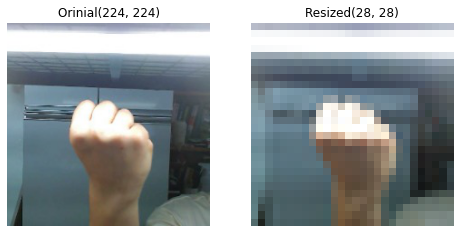

In [22]:
def resize_image(old_image, target_size=TARGET_SIZE):
    target_size = target_size
    new_image = old_image.resize(target_size, Image.ANTIALIAS)
    
    return new_image

sample_path = get_image_sample('사공', 'rock', sample=1)[0]
sample_image = Image.open(sample_path)
sample_resized = resize_image(sample_image)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.imshow(sample_image)
plt.title(f'Orinial{sample_image.size}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(sample_resized)
plt.title(f'Resized{sample_resized.size}')
plt.axis('off')

plt.show()

### 1-2. 데이터 전처리 : 불러오기 및 병합, 변환
- ```load_data()```함수는 노드에 있는 코드 활용
- 데이터 개수와 사이즈를 자유롭게 변경할 수 있도록 ```load_data()``` 코드 수정
- 데이터를 한 곳으로 병합 및 배열(array) 자료형으로 변환

In [23]:
def load_data(img_path, target_size=TARGET_SIZE, color=3): # 자유롭게 사이즈 및 channel 수정 가능
    
    # 데이터의 총 개수 계산
    number_of_data = 0
    for dirpath, dirnames, filenames in os.walk(img_path): 
        number_of_data += len(filenames)
        
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs = np.zeros((number_of_data, *target_size, color), dtype=np.int32) # 코드 수정(생성과 reshape를 한 번에!)
    labels = np.zeros(number_of_data, dtype=np.int32)
    idx=0 # 가위 : 0, 바위 : 1, 보 : 2
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 가위 : 0
        idx = idx + 1

    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 바위 : 1
        idx = idx + 1  
    
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 보 : 2
        idx = idx + 1
        
    return imgs, labels

**불러오기**

In [24]:
train_list = ['사공', '수완', '호성','승민','재성', '지윤', '은서', '정식'] # 학습 데이터 참여 명단
test_list = ['민지', '범진', '보경', '영민', '은영', '재준', '효정'] # 테스트 데이터 참여 명단

train_image_list, train_label_list = [], [] # 이름별 학습 데이터의 집합(리스트)
test_image_list, test_label_list = [], [] # 이름별 테스트 데이터의 집합(리스트)

base_dir = os.getenv("HOME") + '/aiffel/rock_scissor_paper/data'

for train_name in train_list:
    train_dir = os.path.join(base_dir, train_name)               
    train, label = load_data(train_dir, target_size=TARGET_SIZE) # 위에 정의한 load_data()
    train_image_list.append(train)
    train_label_list.append(label)
    
for test_name in test_list:
    test_dir = os.path.join(base_dir, test_name)
    test, label = load_data(test_dir, target_size=TARGET_SIZE)     # 위에 정의한 load_data()
    test_image_list.append(test)
    test_label_list.append(label)

**데이터 병합**

In [25]:
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing

# 이름별 학습 및 테스트 데이터 집합을 합치고 배열(array)로 변환
x_train = np.concatenate(train_image_list, axis=0)
y_train = np.concatenate(train_label_list, axis=0)
x_test = np.concatenate(test_image_list, axis=0)
y_test = np.concatenate(test_label_list, axis=0)

x_train, y_train = shuffle(x_train, y_train) # 학습이 골고루 될 수 있도록 데이터 섞기
# x_test, y_test = shuffle(x_test, y_test)   # 테스트 데이터의 경우 연산의 결과만 보기 때문에 불필요

print(x_train.shape)

(2486, 28, 28, 3)


### 1-3. 데이터 전처리 : 정규화 적용
- 이미지 데이터를 255로 나눠서 0과 1사이의 값으로 정규화

In [26]:
normed_x_train, normed_x_test = (x_train / 255.0), (x_test / 255.0)

print(f'Train Dataset : {normed_x_train.shape}')
print(f'Test Dataset : {normed_x_test.shape}') 
print(f'Max&Min value is : {normed_x_train.max()} / {normed_x_train.mean()}')

Train Dataset : (2486, 28, 28, 3)
Test Dataset : (2103, 28, 28, 3)
Max&Min value is : 1.0 / 0.529202057599656


### 1-4. 데이터 전처리 : 시각화

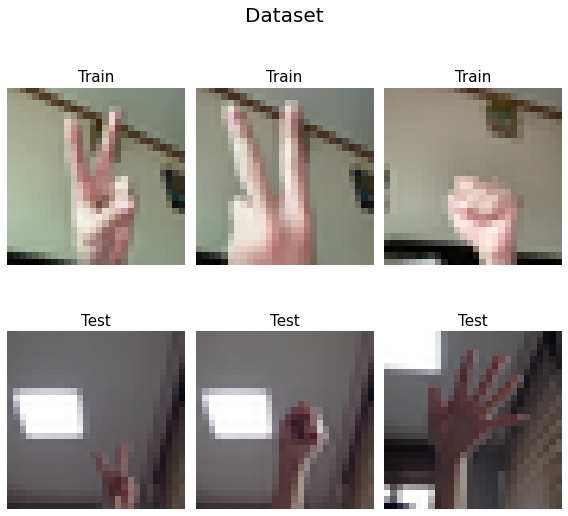

In [27]:
sample_train_images = [x_train[20], x_train[120], x_train[220]]
sample_test_images = [x_test[60], x_test[110], x_test[210]]
sample_images = sample_train_images + sample_test_images

plt.figure(figsize=(8,8))
plt.suptitle("Dataset", fontsize=20)
for i, image in enumerate(sample_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title('Train' if i < 3 else 'Test', fontsize=15)
    plt.axis('off')   
    
plt.tight_layout()

# 2. 딥러닝 모델 설계 및 학습
Tensorflow API를 이용해 가위바위보를 인식하는 딥러닝 모델을 설계 및 학습
#### 주요특징
- 하이퍼파라미터를 바꿔가면서 성능이 가장 좋은 모델 찾기
- 직접 여러 Layer를 쌓아서 모델 정의
- 과적합(Overfitting) 문제를 해결하기 위해 모델 복잡도 낮추기

### 2-1. 모델 설계 : 정의
- 여러 Layer를 쌓아서 딥러닝 모델 정의
- CNN과 Linear Layer를 적절히 사용

In [28]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(*TARGET_SIZE, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_regularizer='l2'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                3216      
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
%matplotlib inline

In [23]:
from tensorflow.keras.applications import VGG16

### 2-2. 모델 설계 : 컴파일
- 최적화 함수 및 손실 함수를 정의

In [29]:
model.compile(optimizer='adam',                         # SGD(Stochastic Gradient Descent)
             loss='sparse_categorical_crossentropy',   # CrossEntroyLoss
             metrics=['accuracy'], )

### 2-3. 모델 학습

In [30]:
history = model.fit(normed_x_train, y_train, epochs=EPOCH)

Epoch 1/10
78/78 [==============================] - 6s 28ms/step - loss: 1.1743 - accuracy: 0.3406
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0813 - accuracy: 0.5165
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 0.8677 - accuracy: 0.6468
Epoch 4/10
78/78 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.7642
Epoch 5/10
78/78 [==============================] - 0s 3ms/step - loss: 0.4927 - accuracy: 0.8341
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 0.3882 - accuracy: 0.8698
Epoch 7/10
78/78 [==============================] - 0s 3ms/step - loss: 0.3019 - accuracy: 0.9182
Epoch 8/10
78/78 [==============================] - 0s 3ms/step - loss: 0.2793 - accuracy: 0.9222
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 0.2334 - accuracy: 0.9426
Epoch 10/10
78/78 [==============================] - 0s 3ms/step - loss: 0.1871 - accuracy: 0.9609


# 3. 학습 결과 확인
- Train 및 Test 정확도 확인
- Confusion Matrix 확인
- Confusion Matrix Report 확인

### Test 정확도 확인

In [31]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

test_loss, test_accuracy = model.evaluate(normed_x_test, y_test, verbose=0)
print(f"Test_accuracy: {(test_accuracy * 100):.4f}%%")

Test_accuracy: 35.2829%%


### Confusion Matrix Report 확인

In [32]:
y_pred = np.argmax(model.predict(normed_x_test), axis=1)

_confusion_matrix = confusion_matrix(y_test, y_pred)
_confusion_report = classification_report(y_test, y_pred, 
                                          target_names=['가위', '바위', '보'], 
                                          output_dict=True)
pd.DataFrame(_confusion_report)

,가위,바위,보,accuracy,macro avg,weighted avg
precision,0.307554,0.445876,0.343399,0.352829,0.365610,0.365610
recall,0.243937,0.246790,0.567760,0.352829,0.352829,0.352829
f1-score,0.272076,0.317723,0.427957,0.352829,0.339252,0.339252
support,701.000000,701.000000,701.000000,0.352829,2103.000000,2103.000000


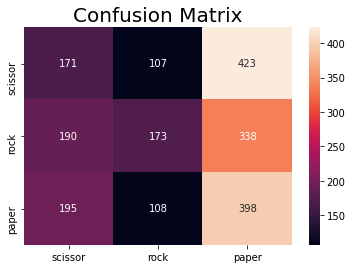

In [33]:
df_confusion = pd.DataFrame(_confusion_matrix.numpy(),
                           columns=['scissor', 'rock', 'paper'],
                           index=['scissor', 'rock', 'paper'])
sns.heatmap(df_confusion, annot=True, fmt='g')
plt.title('Confusion Matrix', fontsize=20)
plt.show()

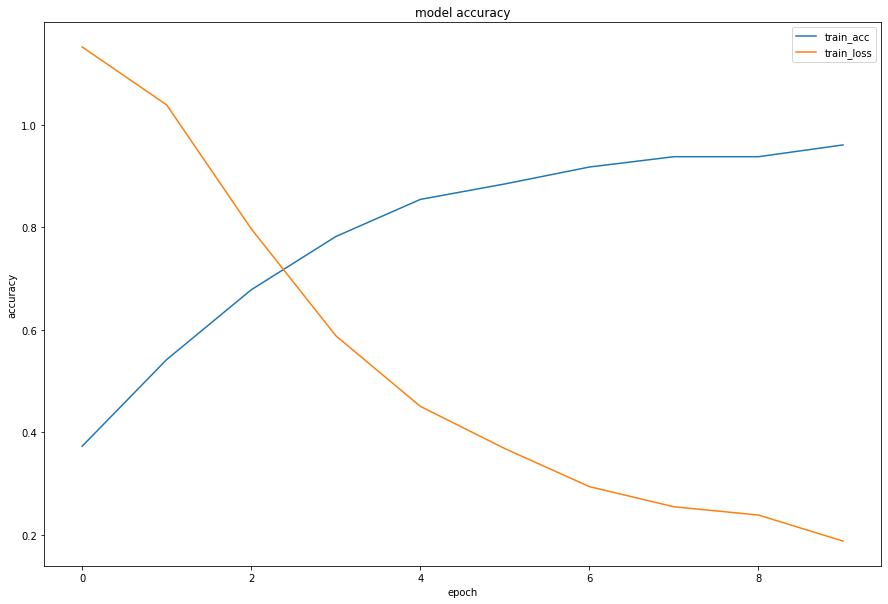

In [34]:
# Plot
plt.figure(figsize=(15,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss', 'val_acc', 'val_loss'], loc='upper right')

## 원 큐에 학습하기

In [120]:
import os
import glob
import random

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from PIL import Image
%matplotlib inline

pont_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname=pont_path, size=18)

TARGET_SIZE = (112, 112)
EPOCH = 30

In [ ]:
def resize_image(old_image, target_size=TARGET_SIZE):
    target_size = target_size
    new_image = old_image.resize(target_size, Image.ANTIALIAS)
    
    return new_image

def load_data(img_path, target_size=TARGET_SIZE, color=3): # 자유롭게 사이즈 및 channel 수정 가능
    
    # 데이터의 총 개수 계산
    number_of_data = 0
    for dirpath, dirnames, filenames in os.walk(img_path): 
        number_of_data += len(filenames)
        
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs = np.zeros((number_of_data, *target_size, color), dtype=np.int32) # 코드 수정(생성과 reshape를 한 번에!)
    labels = np.zeros(number_of_data, dtype=np.int32)
    idx=0 # 가위 : 0, 바위 : 1, 보 : 2
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 가위 : 0
        idx = idx + 1

    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 바위 : 1
        idx = idx + 1  
    
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 보 : 2
        idx = idx + 1
        
    return imgs, labels

train_list = ['사공', '수완', '호성','승민','재성', '지윤', '은서', '정식'] # 학습 데이터 참여 명단
test_list = ['민지', '범진', '보경', '영민', '은영', '재준', '효정'] # 테스트 데이터 참여 명단

train_image_list, train_label_list = [], [] # 이름별 학습 데이터의 집합(리스트)
test_image_list, test_label_list = [], [] # 이름별 테스트 데이터의 집합(리스트)

base_dir = os.getenv("HOME") + '/aiffel/rock_scissor_paper/data'

for train_name in train_list:
    train_dir = os.path.join(base_dir, train_name)               
    train, label = load_data(train_dir, target_size=TARGET_SIZE) # 위에 정의한 load_data()
    train_image_list.append(train)
    train_label_list.append(label)
    
for test_name in test_list:
    test_dir = os.path.join(base_dir, test_name)
    test, label = load_data(test_dir, target_size=TARGET_SIZE)     # 위에 정의한 load_data()
    test_image_list.append(test)
    test_label_list.append(label)

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing

# 이름별 학습 및 테스트 데이터 집합을 합치고 배열(array)로 변환
x_train = np.concatenate(train_image_list, axis=0)
y_train = np.concatenate(train_label_list, axis=0)
x_test = np.concatenate(test_image_list, axis=0)
y_test = np.concatenate(test_label_list, axis=0)

x_train, y_train = shuffle(x_train, y_train) # 학습이 골고루 될 수 있도록 데이터 섞기
# x_test, y_test = shuffle(x_test, y_test)   # 테스트 데이터의 경우 연산의 결과만 보기 때문에 불필요

print(x_train.shape)

norm_layer = preprocessing.Normalization() # Normalization객체 생성
norm_layer.adapt(x_train)                  # Normailzation 파라미터(mean, std 등) 계산
normed_x_train = norm_layer(x_train)       # 데이터에 적용(학습)
normed_x_test = norm_layer(x_test)         # 데이터에 적용(테스트)

print(f'Train Dataset : {normed_x_train.shape}')
print(f'Test Dataset : {normed_x_test.shape}') 
print(f'Max&Min value is : {normed_x_train.numpy().max()} / {normed_x_train.numpy().mean()}')

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(*(TARGET_SIZE), 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_regularizer='l2'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print(model.summary())

In [ ]:
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(112,112, 3))

model_vgg.trainable = False

model = keras.models.Sequential()
model.add(model_vgg)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

(2486, 112, 112, 3)
Train Dataset : (2486, 112, 112, 3)
Test Dataset : (2103, 112, 112, 3)
Max&Min value is : 2.649273157119751 / 5.1245621079942794e-08
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 110, 110, 8)       224       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 8)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_28 (Dense)             (No

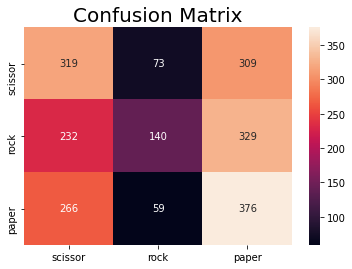

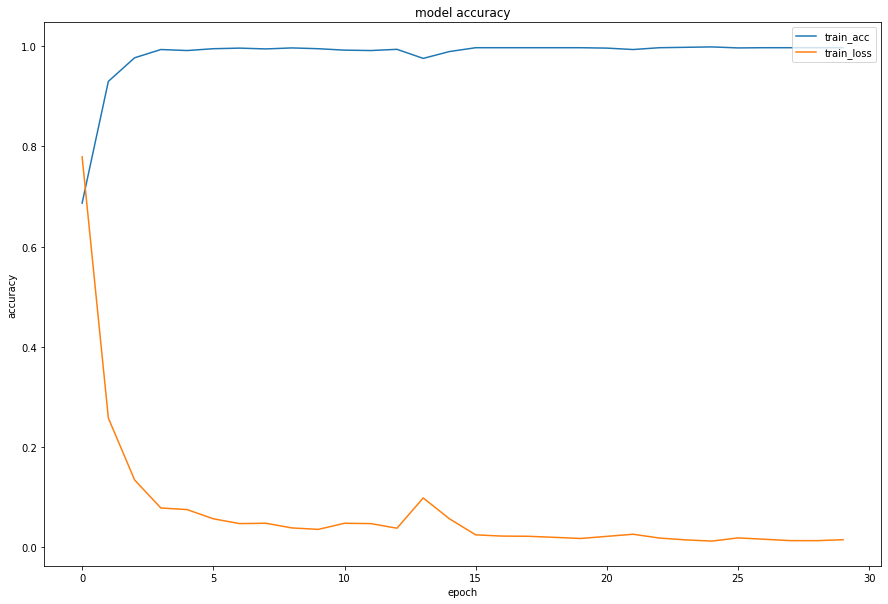

In [121]:
model.compile(optimizer='adam',                         # SGD(Stochastic Gradient Descent)
             loss='sparse_categorical_crossentropy',   # CrossEntroyLoss
             metrics=['accuracy'], )

history = model.fit(normed_x_train, y_train, epochs=EPOCH)

from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

test_loss, test_accuracy = model.evaluate(normed_x_test, y_test, verbose=0)

y_pred = np.argmax(model.predict(normed_x_test), axis=1)

_confusion_matrix = confusion_matrix(y_test, y_pred)
_confusion_report = classification_report(y_test, y_pred, 
                                          target_names=['가위', '바위', '보'], 
                                          output_dict=True)


print(f"test_accuracy: {(test_accuracy * 100):.4f}%%")
pd.DataFrame(_confusion_report)

df_confusion = pd.DataFrame(_confusion_matrix.numpy(),
                           columns=['scissor', 'rock', 'paper'],
                           index=['scissor', 'rock', 'paper'])
sns.heatmap(df_confusion, annot=True, fmt='g')
plt.title('Confusion Matrix', fontsize=20)
plt.show()

# Plot
plt.figure(figsize=(15,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss', 'val_acc', 'val_loss'], loc='upper right')

In [86]:
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(112,112, 3))

model_vgg.trainable = False

model = keras.models.Sequential()
model.add(model_vgg)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 4096)              18878464  
_________________________________________________________________
dropout_8 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                

In [272]:
base_dir = os.getenv("HOME") + '/aiffel/rock_scissor_paper/data'
classes = ['rock', 'scissor', 'paper']
team_list = ['사공', '수완', '호성', '경은', '승민', \
             '재성', '지윤', '은서', '정식']

print('Name (rock, scissor, paper)')
print('*'*30)
for name in team_list:
    len_rock = len(glob.glob(os.path.join(base_dir, name, 'rock/*.jpg')))
    len_scissor = len(glob.glob(os.path.join(base_dir, name, 'scissor/*.jpg')))
    len_paper = len(glob.glob(os.path.join(base_dir, name, 'paper/*.jpg')))
        
    print(name, (len_rock, len_scissor, len_paper))

Name (rock, scissor, paper)
******************************
사공 (122, 111, 117)
수완 (101, 102, 102)
호성 (100, 100, 100)
경은 (100, 100, 100)
승민 (100, 100, 100)
재성 (100, 100, 100)
지윤 (100, 100, 100)
은서 (103, 101, 103)
정식 (106, 113, 105)


In [273]:
train_dir = os.path.join(base_dir, '승민')
test_dir = os.path.join(base_dir, '경은')

print(f'Train directory : {train_dir}')
print(f'Test directory : {test_dir}')

Train directory : /aiffel/aiffel/rock_scissor_paper/data/승민
Test directory : /aiffel/aiffel/rock_scissor_paper/data/경은


In [22]:
def load_data(img_path, target_size=(28,28)): # 정규화 여부를 인자로 추가
    
    number_of_data = 0
    for dirpath, dirnames, filenames in os.walk(img_path): # 데이터의 총 개수을 계산한다.
        number_of_data += len(filenames)
    
    img_size = target_size[0]
    color = 3
    
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0 # 가위 : 0, 바위 : 1, 보 : 2
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 가위 : 0
        idx = idx + 1

    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 바위 : 1
        idx = idx + 1  
    
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img, target_size=target_size)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 보 : 2
        idx = idx + 1
        
    return imgs, labels

# (x_train, y_train) = load_data(train_dir)
# (x_test, y_test) = load_data(test_dir)
# x_train = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
# x_test = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print(f"x_train shape : {x_train.shape} / y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape} / y_test shape : {y_test.shape}")

x_train shape : (0, 112, 112, 3) / y_train shape : (0,)
x_test shape : (0, 112, 112, 3) / y_test shape : (0,)


In [275]:
from sklearn.utils import shuffle
import numpy as np


x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 576)             

Epoch 46/60
8/8 [==============================] - 0s 8ms/step - loss: 3.0944e-04 - accuracy: 1.0000 - val_loss: 3.8649e-04 - val_accuracy: 1.0000
Epoch 47/60
8/8 [==============================] - 0s 9ms/step - loss: 1.7916e-04 - accuracy: 1.0000 - val_loss: 3.6661e-04 - val_accuracy: 1.0000
Epoch 48/60
8/8 [==============================] - 0s 9ms/step - loss: 2.6562e-04 - accuracy: 1.0000 - val_loss: 3.5364e-04 - val_accuracy: 1.0000
Epoch 49/60
8/8 [==============================] - 0s 9ms/step - loss: 1.7938e-04 - accuracy: 1.0000 - val_loss: 3.3186e-04 - val_accuracy: 1.0000
Epoch 50/60
8/8 [==============================] - 0s 8ms/step - loss: 1.8462e-04 - accuracy: 1.0000 - val_loss: 3.2774e-04 - val_accuracy: 1.0000
Epoch 51/60
8/8 [==============================] - 0s 8ms/step - loss: 1.5569e-04 - accuracy: 1.0000 - val_loss: 3.1846e-04 - val_accuracy: 1.0000
Epoch 52/60
8/8 [==============================] - 0s 10ms/step - loss: 1.8693e-04 - accuracy: 1.0000 - val_loss: 2.99

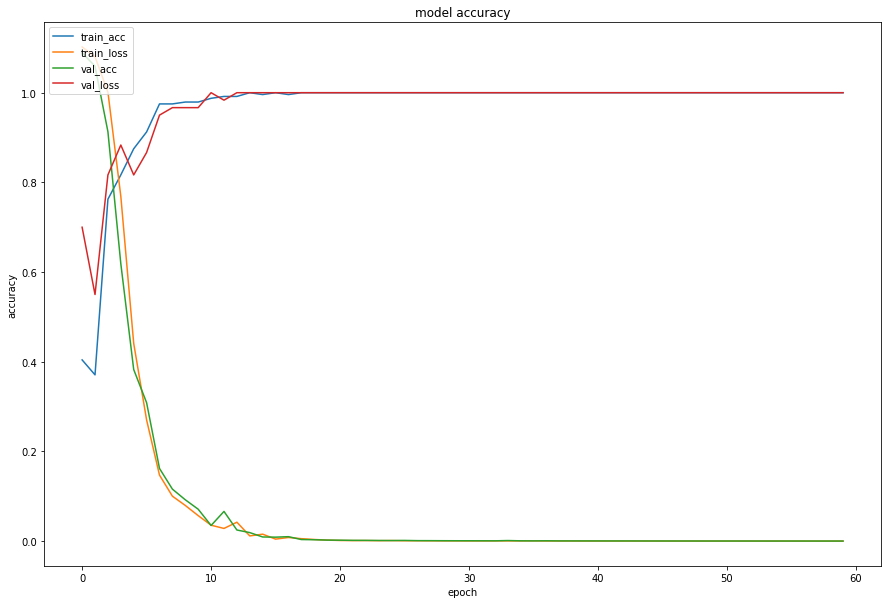

In [276]:
import tensorflow as tf
from tensorflow import keras

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print(model.summary())

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'], )

history = model.fit(x_train, y_train, epochs=60, validation_split = 0.2, shuffle=True)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

plt.figure(figsize=(15,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss', 'val_acc', 'val_loss'], loc='upper left')

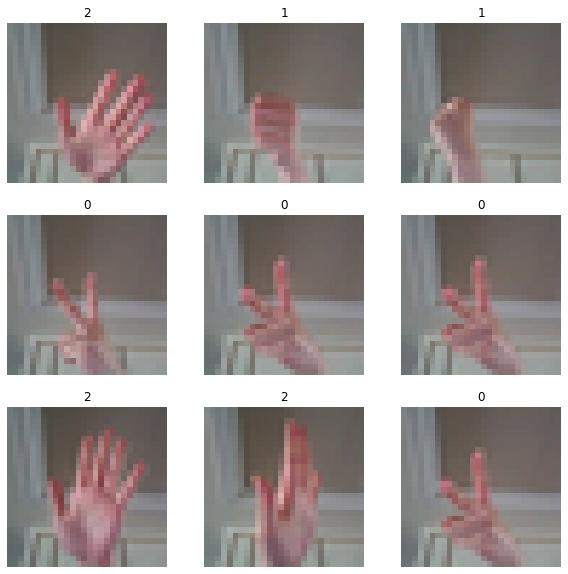

In [277]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(zip(x_test[:9], y_test[:9])):
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

In [298]:
y_test

array([2, 1, 1, 0, 0, 0, 2, 2, 0, 1, 1, 1, 2, 1, 2, 2, 2, 0, 2, 2, 0, 1,
       1, 0, 1, 0, 2, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 2, 2, 1, 0,
       0, 1, 2, 0, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1,
       1, 2, 1, 2, 2, 1, 2, 1, 2, 0, 0, 1, 0, 0, 1, 1, 2, 2, 2, 1, 2, 2,
       1, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0,
       1, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 1, 2, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 0, 2, 1, 0, 0, 2, 2, 2, 1, 0, 2,
       0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0,
       2, 2, 1, 0, 0, 2, 1, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0,
       1, 1, 2, 2, 0, 2, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0,
       0, 1, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 1, 1, 2, 2,
       0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 2, 2, 1, 0, 2,
       2, 1, 0, 2, 0, 1, 2, 1, 0, 0, 1, 0, 2, 2], d

In [297]:
np.argmax(model.predict(x_test), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [296]:
model.predict(x_test).shape

(300, 3)

In [184]:
real_dir = os.path.join(base_dir, 'data')
real_image_list = glob.glob(real_dir + '/*.jpg')
real_image_list

['/aiffel/aiffel/rock_scissor_paper/data/data/paper.jpg',
 '/aiffel/aiffel/rock_scissor_paper/data/data/scissor.jpg',
 '/aiffel/aiffel/rock_scissor_paper/data/data/rock.jpg']

In [185]:
paper = Image.open(real_image_list[0])
scissor = Image.open(real_image_list[1])
rock = Image.open(real_image_list[2])

In [186]:
paper_resize = resize_image(paper)
scissor_resize = resize_image(scissor)
rock_resize = resize_image(rock)

In [187]:
type(rock_resize)

PIL.Image.Image

In [188]:
np.array(rock_resize).shape

(28, 28, 3)

In [194]:
model.predict(np.array(scissor_resize).reshape(-1,28,28,3)).argmax()

2

# 모두 합친 것

In [195]:
team_list

['사공', '수완', '호성', '경은', '승민', '재성', '지윤', '은서', '정식']

In [196]:
*train_list, test_list = team_list
train_list

test_list

train_dir = os.path.join(base_dir, '승민')
test_dir = os.path.join(base_dir, '경은')

print(f'Train directory : {train_dir}')
print(f'Test directory : {test_dir}')

['사공', '수완', '호성', '경은', '승민', '재성', '지윤', '은서']

In [206]:
train_image_list, train_label_list = [], []
for train_name in train_list:
    train_dir = os.path.join(base_dir, train_name)
    train, label = load_data(train_dir, target_size=(28,28))
    train_image_list.append(train)
    train_label_list.append(label)

x_train = np.concatenate(train_image_list, axis=0)
y_train = np.concatenate(train_label_list, axis=0)

test_dir = os.path.join(base_dir, test_dir)
x_test, y_test = load_data(test_dir, target_size=(28,28))

from sklearn.utils import shuffle
import numpy as np


x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

In [210]:
import tensorflow as tf
from tensorflow import keras

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print(model.summary())

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy', 'Precision'], )

history = model.fit(x_train, y_train, epochs=60, validation_split = 0.2, shuffle=True)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

plt.figure(figsize=(15,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss', 'val_acc', 'val_loss'], loc='upper left')

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 576)             

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:758 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:408 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:1291 update_state  **
        sample_weight=sample_weight)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/metrics_utils.py:354 update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 3) and (None, 1) are incompatible
